In [91]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras.models import Sequential
from keras import regularizers
from keras.utils.vis_utils import plot_model
#from keras.optimizers import RMSprop, Adam, SGD
from datetime import datetime, time
import matplotlib.pyplot as plt
import seaborn as sns #statistical data visualization library based on matplotlib. seaborn provides a high-level interface for creating attractive and informative statistical graphics
import os


from sklearn.preprocessing import StandardScaler, RobustScaler
#standard scaler:
# StandardScaler scales the features by removing the mean and scaling to unit variance. 
# It transforms the data such that it has a mean of 0 and a standard deviation of 1.
# z = (x - mean) / standard_deviation
# StandardScaler is sensitive to outliers. 

#robust scaler
# RobustScaler, on the other hand, is less sensitive to outliers. 
# It scales the features using the interquartile range (IQR). It subtracts the median and divides by the IQR, making it robust to the presence of outliers.
# z = (x - median) / IQR

#Use StandardScaler when the data are normally distributed and does not contain many outliers.

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn import datasets, linear_model
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, ElasticNetCV, Lasso
# Lasso regression is a type of linear regression with L1 regularization, which can be used for feature selection and regularization.
# ElasticNet is used for linear regression with combined L1 and L2 priors as regularizers. ElasticNetCV performs cross-validated optimization to find the best combination of the alpha (regularization strength) and l1_ratio (mixing parameter) parameters for Elastic Net regression.
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR #Support Vector Machines (SVM) family in scikit-learn
from scipy.stats import randint
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import  AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor 
# ADABoost is used for building an ensemble of decision tree regressors through adaptive boosting. Adaptive boosting (AdaBoost) is a machine learning algorithm that combines the predictions of multiple base estimators (in this case, decision tree regressors) to improve the overall accuracy of the model
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from xgboost.sklearn import XGBRegressor # popular gradient boosting library
import lightgbm as lgbm
from mlxtend.regressor import StackingRegressor

# Data Loading

In [22]:
current_directory = os.getcwd()

# Path to your Excel file
file_path = current_directory+'/dataset.csv'
data = pd.read_csv(file_path)
data.head()

,temperature_2_m_above_gnd,relative_humidity_2_m_above_gnd,mean_sea_level_pressure_MSL,total_precipitation_sfc,snowfall_amount_sfc,total_cloud_cover_sfc,high_cloud_cover_high_cld_lay,medium_cloud_cover_mid_cld_lay,low_cloud_cover_low_cld_lay,shortwave_radiation_backwards_sfc,...,wind_direction_10_m_above_gnd,wind_speed_80_m_above_gnd,wind_direction_80_m_above_gnd,wind_speed_900_mb,wind_direction_900_mb,wind_gust_10_m_above_gnd,angle_of_incidence,zenith,azimuth,generated_power_kw
0,2.17,31,1035.0,0.0,0.0,0.0,0,0,0,0.00,...,312.71,9.36,22.62,6.62,337.62,24.48,58.753108,83.237322,128.33543,454.10095
1,2.31,27,1035.1,0.0,0.0,0.0,0,0,0,1.78,...,294.78,5.99,32.74,4.61,321.34,21.96,45.408585,75.143041,139.65530,1411.99940
2,3.65,33,1035.4,0.0,0.0,0.0,0,0,0,108.58,...,270.00,3.89,56.31,3.76,286.70,14.04,32.848282,68.820648,152.53769,2214.84930
3,5.82,30,1035.4,0.0,0.0,0.0,0,0,0,258.10,...,323.13,3.55,23.96,3.08,339.44,19.80,22.699288,64.883536,166.90159,2527.60920
4,7.73,27,1034.4,0.0,0.0,0.0,0,0,0,375.58,...,10.01,6.76,25.20,6.62,22.38,16.56,19.199908,63.795208,182.13526,2640.20340


# Data Exploration

<Axes: >

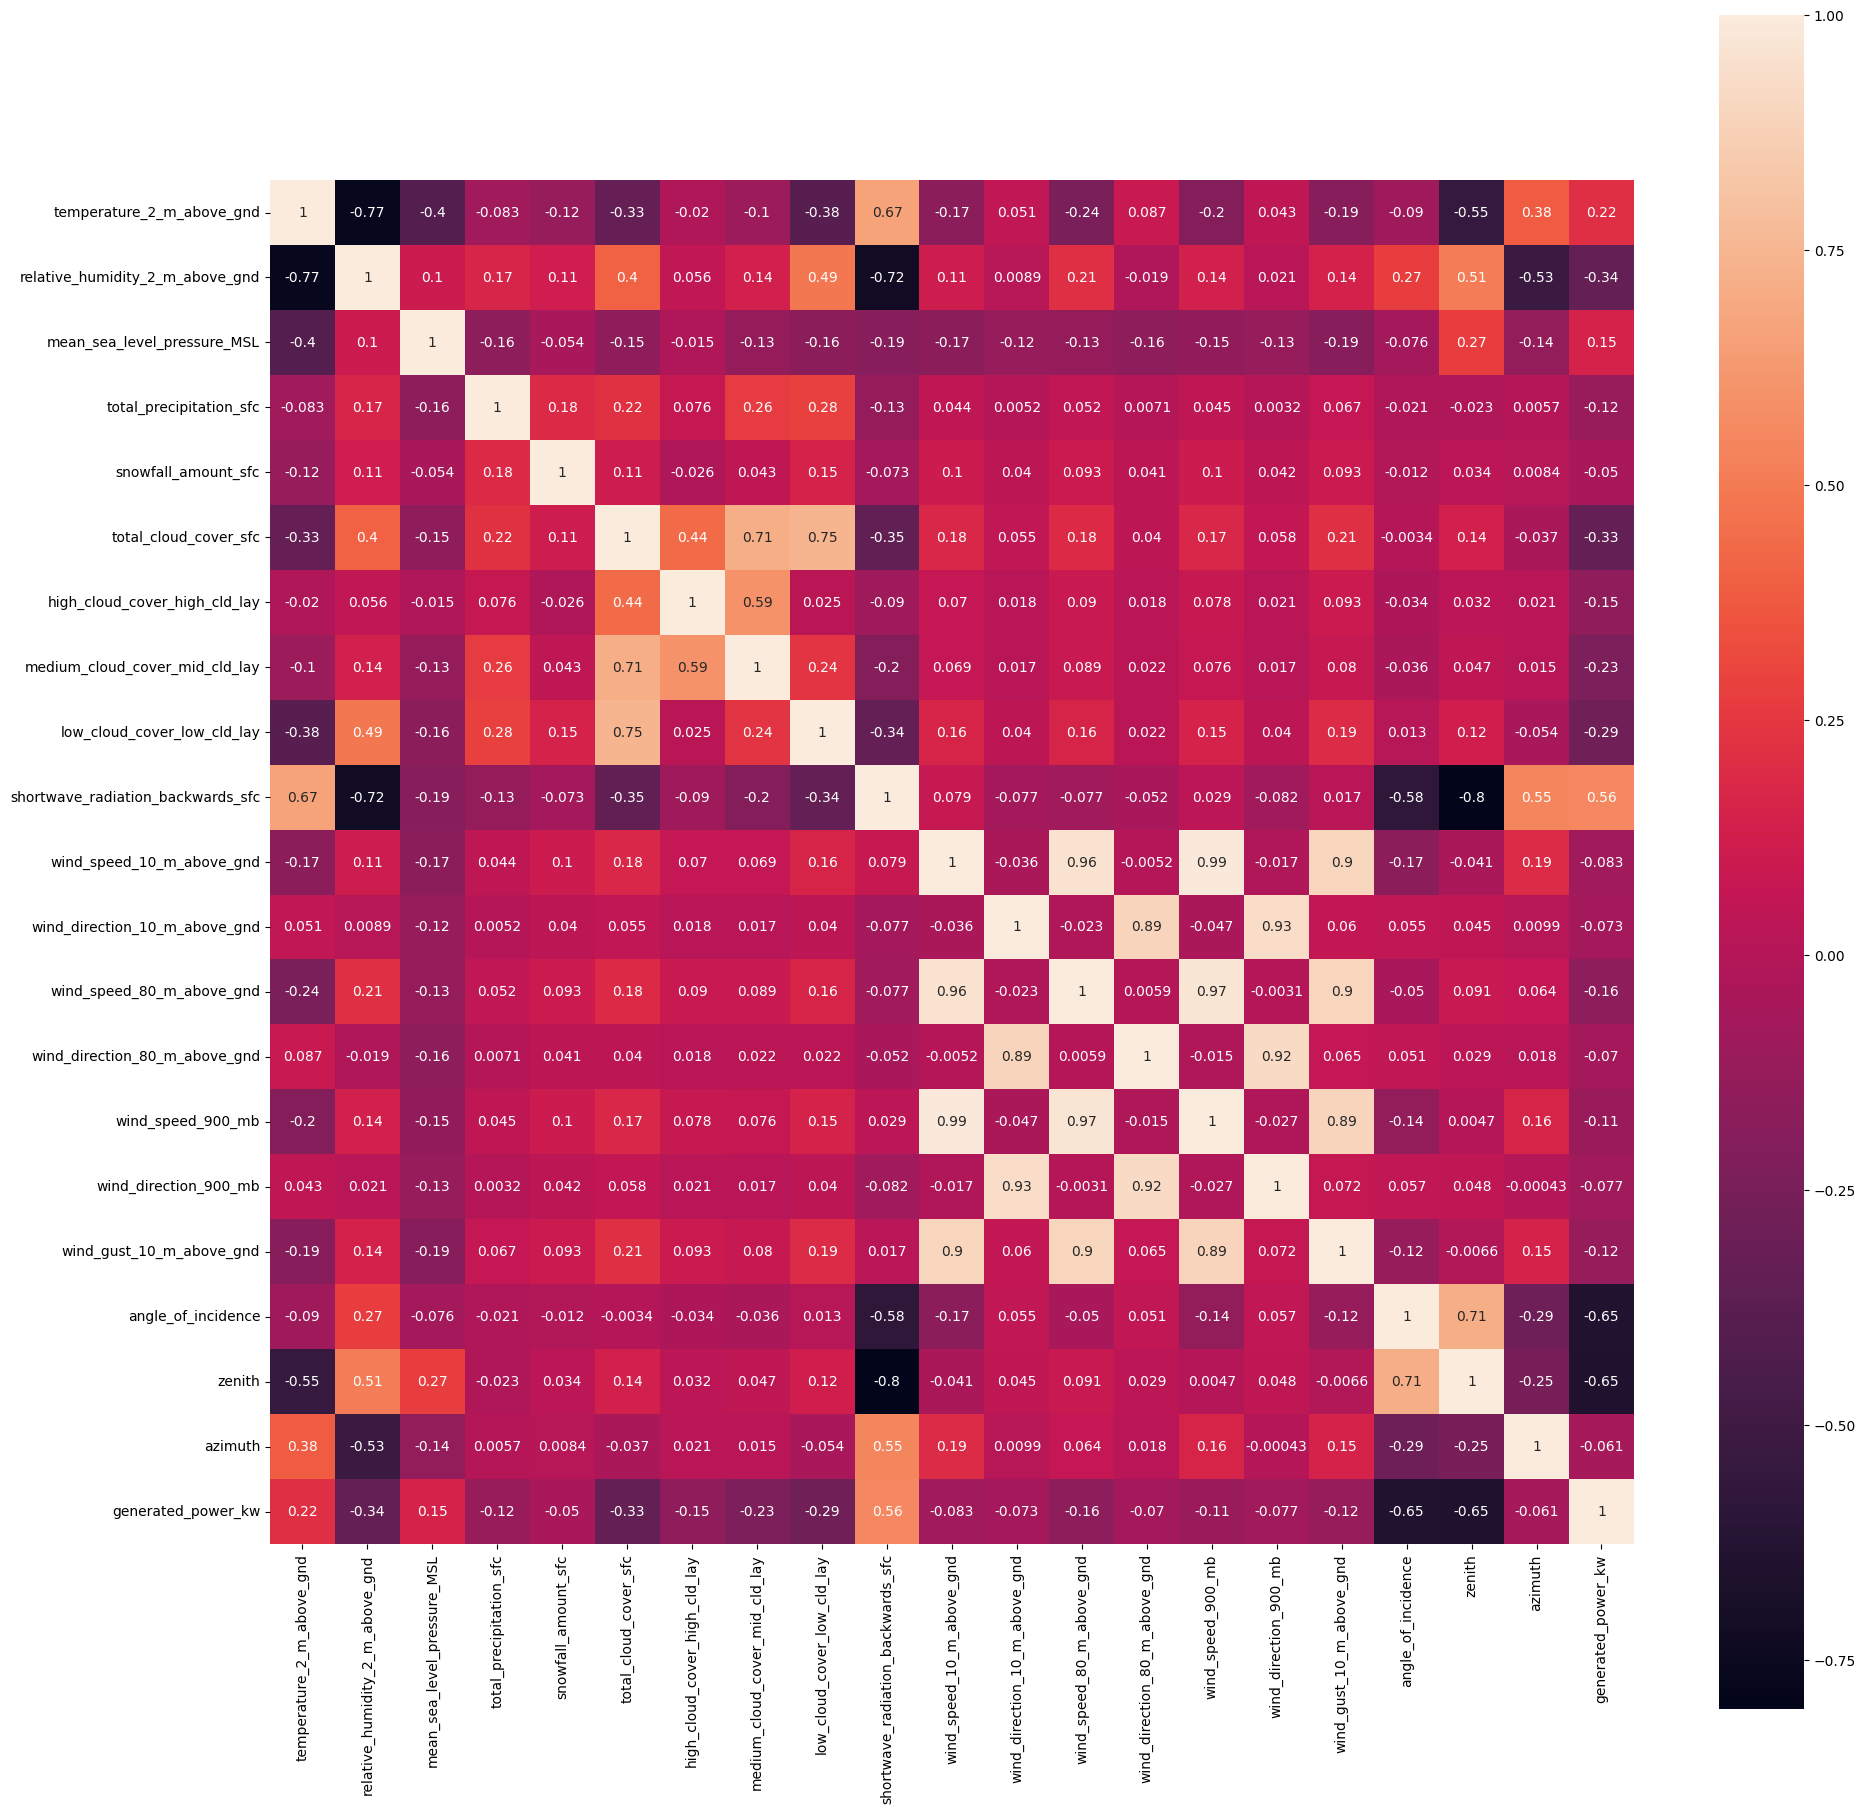

In [5]:
corr_mat = data.corr()
plt.figure(figsize = (22,22))
sns.heatmap(corr_mat, annot = True, square = True)

In [6]:
corr_mat["generated_power_kw"].sort_values(ascending=False)

generated_power_kw                   1.000000
shortwave_radiation_backwards_sfc    0.556148
temperature_2_m_above_gnd            0.217280
mean_sea_level_pressure_MSL          0.150551
snowfall_amount_sfc                 -0.049508
azimuth                             -0.061184
wind_direction_80_m_above_gnd       -0.069941
wind_direction_10_m_above_gnd       -0.073257
wind_direction_900_mb               -0.077435
wind_speed_10_m_above_gnd           -0.083043
wind_speed_900_mb                   -0.107615
total_precipitation_sfc             -0.118442
wind_gust_10_m_above_gnd            -0.122808
high_cloud_cover_high_cld_lay       -0.147723
wind_speed_80_m_above_gnd           -0.157899
medium_cloud_cover_mid_cld_lay      -0.227834
low_cloud_cover_low_cld_lay         -0.288066
total_cloud_cover_sfc               -0.334338
relative_humidity_2_m_above_gnd     -0.336783
angle_of_incidence                  -0.646537
zenith                              -0.649991
Name: generated_power_kw, dtype: f

In [69]:
# What are the most important variables per a random forest model?
X = data.loc[:, (data.columns != 'generated_power_kw')]
Y = data["generated_power_kw"]

random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
random_forest.fit(X, Y)

# Get feature importances
feature_importances = random_forest.feature_importances_

# Create a DataFrame to store feature names and their corresponding importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top N most important features
top_n = 20  # Change this number to display a different number of top features
print(f"Top {top_n} most important features:")
print(feature_importance_df.head(top_n))

Top 20 most important features:
                              Feature  Importance
17                 angle_of_incidence    0.380019
5               total_cloud_cover_sfc    0.136784
18                             zenith    0.129217
19                            azimuth    0.100539
9   shortwave_radiation_backwards_sfc    0.072512
1     relative_humidity_2_m_above_gnd    0.029840
2         mean_sea_level_pressure_MSL    0.027338
16           wind_gust_10_m_above_gnd    0.022139
0           temperature_2_m_above_gnd    0.019338
8         low_cloud_cover_low_cld_lay    0.011106
13      wind_direction_80_m_above_gnd    0.009826
11      wind_direction_10_m_above_gnd    0.009770
15              wind_direction_900_mb    0.009121
10          wind_speed_10_m_above_gnd    0.008464
12          wind_speed_80_m_above_gnd    0.008339
14                  wind_speed_900_mb    0.008081
6       high_cloud_cover_high_cld_lay    0.007035
7      medium_cloud_cover_mid_cld_lay    0.006056
3             tota

# Data Cleaning and Prep

In [23]:
# are there any blanks/nulls in columns
print([col for col in data.columns if data[col].isnull().any()])

[]


In [25]:
# Standardize data
variables_to_exclude_from_standardizing = [
    'generated_power_kw' #target variable
]

columns_to_standardize = data.columns.difference(variables_to_exclude_from_standardizing)

# Create a StandardScaler object
scaler = StandardScaler()

# Standardize only the selected columns
data[columns_to_standardize] = scaler.fit_transform(data[columns_to_standardize])

In [27]:
# split data into input and target variables
x = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
y = np.reshape(y, (-1,1))
print(x.shape, y.shape)

(4213, 20) (4213, 1)


In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
print("Train Shape: {} {} \nTest Shape: {} {}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

Train Shape: (3370, 20) (3370, 1) 
Test Shape: (843, 20) (843, 1)


# Models

In [29]:
#for displaying scores at end of each model
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

## Linear Regression

In [32]:
# linear regression
lm = LinearRegression()
model = lm.fit(x_train, y_train)
print ("R^2 is: \n", model.score(x_test, y_test))


lin_scores = cross_val_score(lm, x, y,
                             scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)

#Display scores
display_scores(lin_rmse_scores)

R^2 is: 
 0.7180084563489013
Scores: [839.17999429 448.77535591 378.88395294 476.52739551 621.03142824]
Mean: 552.8796253794214
Standard deviation: 163.43465080802088


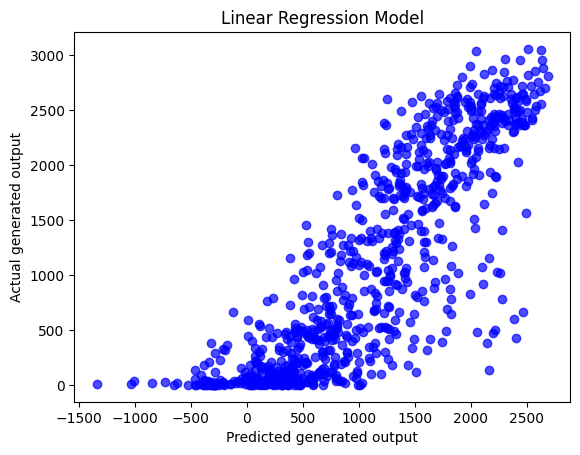

In [34]:
actual_values = y_test
predictions = model.predict(x_test)
plt.scatter(predictions, actual_values, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted generated output')
plt.ylabel('Actual generated output')
plt.title('Linear Regression Model')
plt.show()

## Ridge Regression

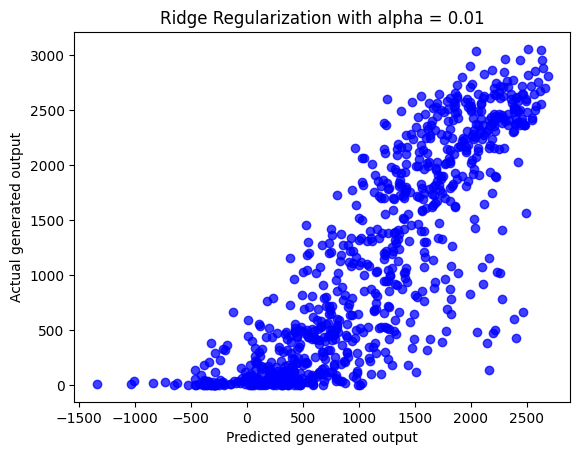

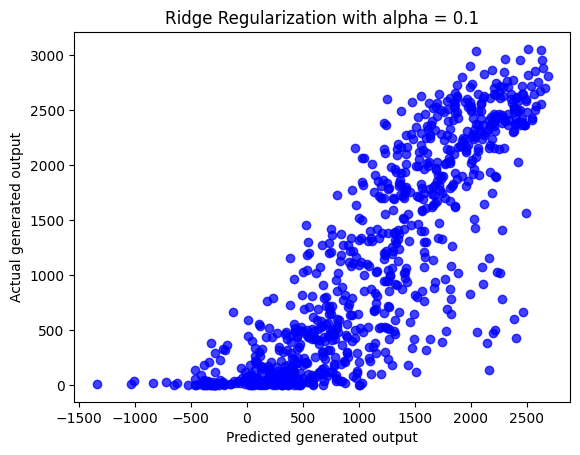

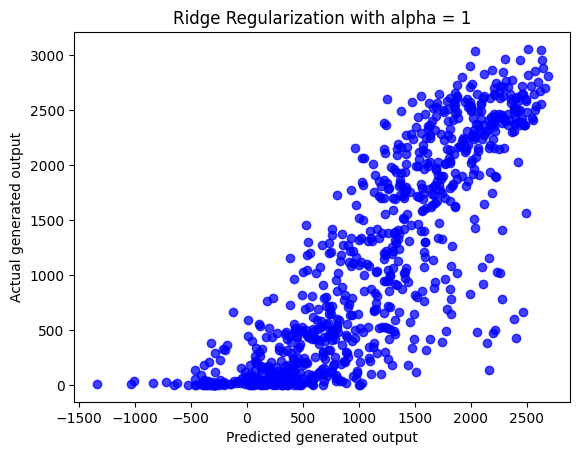

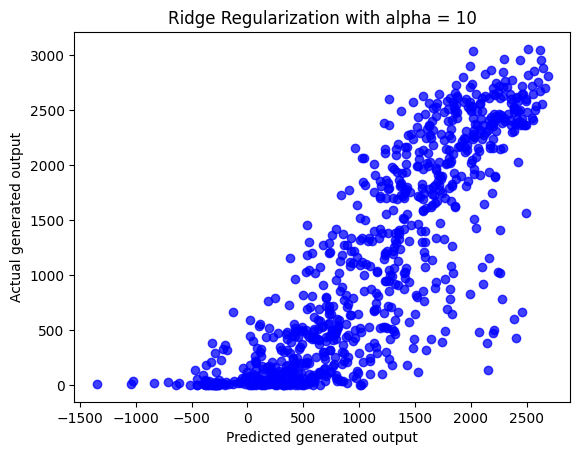

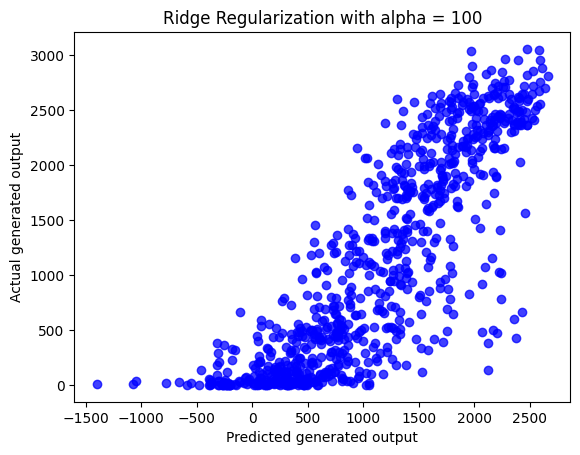

In [37]:
# Ridge

for i in range (-2, 3):
    alpha = 10**i
    rm = linear_model.Ridge(alpha=alpha)
    ridge_model = rm.fit(x_train, y_train)
    preds_ridge = ridge_model.predict(x_test)

    plt.scatter(preds_ridge, actual_values, alpha=.75, color='b')
    plt.xlabel('Predicted generated output')
    plt.ylabel('Actual generated output')
    plt.title('Ridge Regularization with alpha = {}'.format(alpha))
    overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    ridge_model.score(x_test, y_test),
                    mean_squared_error(y_test, preds_ridge))
#    plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
    plt.show()

## Elastic Net

In [39]:
# REGULARIZATION WITH ELASTIC NET
# Set parameters to iterate over
alphas = [0.000542555]
l1ratio = [0.1, 0.3,0.5, 0.9, 0.95, 0.99, 1]
# Model with iterative fitting 
elastic_cv = ElasticNetCV(cv=5, max_iter=1e7, alphas=alphas,  l1_ratio=l1ratio)

# Fit the model to the data
estc_reg = elastic_cv.fit(x_train, y_train)

# Predict on the test set from our training set
y_pred = estc_reg.predict(x_test)
print("ElasticRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred)))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ElasticRegressor RMSE: 507.38871976811043


## Lasso

In [40]:
# REGULARIZATION WITH LASSO
# Set parameters to iterate over
parameters= {'alpha':[0.0001,0.0009,0.001,0.002,0.003,0.01,0.1,1,10,100]}

# Instantiate reg for gridsearch
lasso=Lasso()
# Conduct the gridsearch
lasso_reg = GridSearchCV(lasso, param_grid=parameters, scoring='neg_mean_squared_error', cv=15)

# Instantiate new lasso reg with best params
lasso_reg = Lasso(alpha= 0.0009)

# Fit the model to the data
lasso_reg.fit(x_train,y_train)

# Predict on the test set from our training set
y_pred = lasso_reg.predict(x_test)
print("LassoRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred)))

LassoRegressor RMSE: 507.5306148134917


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.461e+06, tolerance: 2.935e+05
  model = cd_fast.enet_coordinate_descent(


## Random Forest

In [42]:
# RANDOM FOREST

# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 500]
}

# Instantiate reg for gridsearch
rf = RandomForestRegressor()

# Conduct the gridsearch
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)

# Create a random forest with best parameters
rf_reg = RandomForestRegressor(bootstrap =  True, max_depth = 80, max_features = 'auto', min_samples_leaf = 3,
                               min_samples_split = 8, n_estimators = 300, n_jobs=-1, random_state=12)

# Fit the model to the data
rf_reg.fit(x_train, y_train)

# Predict on the test set from our training set
y_pred_rf = rf_reg.predict(x_test)
print("RandomForestRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred_rf)))

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   4.3s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   4.3s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   4.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   4.1s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=  20.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=  20.2s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=  20.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=  17.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=  17.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=  17.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=500; total time=  17.2s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=500; total time=  16.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=500; total time=  16.8s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   5.8s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=500; total time=  16.8s
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=500; total time=  16.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=500; total time=  16.8s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   6.0s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   5.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=   6.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=   6.0s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=   6.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=500; total time=   6.6s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=500; total time=   6.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=500; total time=   6.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=500; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=500; total time=   6.1s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=500; total time=   6.0s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   6.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   6.5s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   6.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=   6.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=   6.5s
[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=   6.4s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=500; total time=   6.4s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=500; total time=   6.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=500; total time=   6.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=12, n_estimators=500; total time=   6.2s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=12, n_estimators=500; total time=   6.0s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=12, n_estimators=500; total time=   6.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   5.1s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   5.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   5.0s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=  23.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=  22.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=  21.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=  17.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=  17.5s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=  17.5s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=500; total time=  16.3s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=500; total time=  16.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=500; total time=  19.0s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   5.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=500; total time=  20.0s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=500; total time=  19.4s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=500; total time=  19.5s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   6.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   7.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=   7.5s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=   6.9s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=   6.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=500; total time=   9.5s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=500; total time=   9.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=500; total time=  10.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=500; total time=   6.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=500; total time=   6.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=500; total time=   7.0s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   1.1s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   7.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   8.0s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   8.1s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   2.5s
[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=  10.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=  10.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=3, min_samples_split=12, n_estimators=500; total time=   9.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=5, min_samples_split=12, n_estimators=100; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=500; total time=   6.7s
[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=500; total time=   6.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=500; total time=   7.5s
[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=5, min_samples_split=12, n_estimators=500; total time=   7.4s
[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=5, min_samples_split=12, n_estimators=500; total time=   7.2s
[CV] END bootstrap=True, max_depth=100, max_features=log2, min_samples_leaf=5, min_samples_split=12, n_estimators=500; total time=   7.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 500}


/var/folders/_n/rrgq9bp931j_96jz07qrpmfw0000gn/T/ipykernel_59962/1462264861.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_reg.fit(x_train, y_train)


RandomForestRegressor RMSE: 411.10590587721407


## ADA Boost

In [44]:
# ADA BOOST

# Grid search for best params
param_grid = {
 'n_estimators': [50, 100, 200],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['linear', 'square', 'exponential']
 }

# Instantiate reg for gridsearch
ab_reg = AdaBoostRegressor()

# Conduct the gridsearch
grid_search = GridSearchCV(estimator = ab_reg, param_grid = param_grid, cv = 4, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)

# Create a random forest with best parameters
ab_reg = AdaBoostRegressor(learning_rate =1, loss = 'exponential', n_estimators =  50, random_state= 12)

# Fit the model to the data
ab_reg.fit(x_train, y_train)

# Predict on the test set from our training set
y_pred_ab = ab_reg.predict(x_test)
print("AdaBoostRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred_ab)))

Fitting 4 folds for each of 45 candidates, totalling 180 fits


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validati

[CV] END ...learning_rate=0.01, loss=linear, n_estimators=50; total time=   2.5s
[CV] END ...learning_rate=0.01, loss=linear, n_estimators=50; total time=   2.5s
[CV] END ...learning_rate=0.01, loss=linear, n_estimators=50; total time=   2.5s
[CV] END ...learning_rate=0.01, loss=linear, n_estimators=50; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validati

[CV] END ..learning_rate=0.01, loss=linear, n_estimators=100; total time=   4.0s
[CV] END ..learning_rate=0.01, loss=linear, n_estimators=100; total time=   4.1s
[CV] END ..learning_rate=0.01, loss=linear, n_estimators=100; total time=   4.1s
[CV] END ..learning_rate=0.01, loss=linear, n_estimators=100; total time=   4.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validati

[CV] END ..learning_rate=0.01, loss=linear, n_estimators=200; total time=   4.6s
[CV] END ..learning_rate=0.01, loss=linear, n_estimators=200; total time=   4.7s
[CV] END ..learning_rate=0.01, loss=linear, n_estimators=200; total time=   4.7s
[CV] END ..learning_rate=0.01, loss=linear, n_estimators=200; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validati

[CV] END ...learning_rate=0.01, loss=square, n_estimators=50; total time=   2.0s
[CV] END ...learning_rate=0.01, loss=square, n_estimators=50; total time=   1.9s
[CV] END ...learning_rate=0.01, loss=square, n_estimators=50; total time=   2.0s
[CV] END ...learning_rate=0.01, loss=square, n_estimators=50; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validati

[CV] END ..learning_rate=0.01, loss=square, n_estimators=100; total time=   2.5s
[CV] END ..learning_rate=0.01, loss=square, n_estimators=100; total time=   2.5s
[CV] END ..learning_rate=0.01, loss=square, n_estimators=100; total time=   2.6s
[CV] END ..learning_rate=0.01, loss=square, n_estimators=100; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validati

[CV] END ..learning_rate=0.01, loss=square, n_estimators=200; total time=   4.8s
[CV] END ..learning_rate=0.01, loss=square, n_estimators=200; total time=   4.8s
[CV] END ..learning_rate=0.01, loss=square, n_estimators=200; total time=   4.9s
[CV] END ..learning_rate=0.01, loss=square, n_estimators=200; total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validati

[CV] END learning_rate=0.01, loss=exponential, n_estimators=50; total time=   1.2s
[CV] END learning_rate=0.01, loss=exponential, n_estimators=50; total time=   1.2s
[CV] END learning_rate=0.01, loss=exponential, n_estimators=50; total time=   1.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.01, loss=exponential, n_estimators=50; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.01, loss=exponential, n_estimators=100; total time=   2.9s
[CV] END learning_rate=0.01, loss=exponential, n_estimators=100; total time=   3.0s
[CV] END learning_rate=0.01, loss=exponential, n_estimators=100; total time=   2.9s
[CV] END learning_rate=0.01, loss=exponential, n_estimators=100; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validati

[CV] END learning_rate=0.01, loss=exponential, n_estimators=200; total time=   4.6s
[CV] END learning_rate=0.01, loss=exponential, n_estimators=200; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.01, loss=exponential, n_estimators=200; total time=   4.6s
[CV] END learning_rate=0.01, loss=exponential, n_estimators=200; total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.05, loss=linear, n_estimators=50; total time=   1.3s
[CV] END ...learning_rate=0.05, loss=linear, n_estimators=50; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.05, loss=linear, n_estimators=50; total time=   1.4s
[CV] END ...learning_rate=0.05, loss=linear, n_estimators=50; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..learning_rate=0.05, loss=linear, n_estimators=100; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..learning_rate=0.05, loss=linear, n_estimators=100; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..learning_rate=0.05, loss=linear, n_estimators=100; total time=   2.8s
[CV] END ..learning_rate=0.05, loss=linear, n_estimators=100; total time=   2.8s
[CV] END ..learning_rate=0.05, loss=linear, n_estimators=200; total time=   4.9s
[CV] END ..learning_rate=0.05, loss=linear, n_estimators=200; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..learning_rate=0.05, loss=linear, n_estimators=200; total time=   4.6s
[CV] END ..learning_rate=0.05, loss=linear, n_estimators=200; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.05, loss=square, n_estimators=50; total time=   1.4s
[CV] END ...learning_rate=0.05, loss=square, n_estimators=50; total time=   1.4s
[CV] END ...learning_rate=0.05, loss=square, n_estimators=50; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.05, loss=square, n_estimators=50; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..learning_rate=0.05, loss=square, n_estimators=100; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..learning_rate=0.05, loss=square, n_estimators=100; total time=   2.8s
[CV] END ..learning_rate=0.05, loss=square, n_estimators=100; total time=   2.8s
[CV] END ..learning_rate=0.05, loss=square, n_estimators=100; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..learning_rate=0.05, loss=square, n_estimators=200; total time=   4.5s
[CV] END ..learning_rate=0.05, loss=square, n_estimators=200; total time=   4.3s
[CV] END ..learning_rate=0.05, loss=square, n_estimators=200; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ..learning_rate=0.05, loss=square, n_estimators=200; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.05, loss=exponential, n_estimators=50; total time=   1.4s
[CV] END learning_rate=0.05, loss=exponential, n_estimators=50; total time=   1.4s
[CV] END learning_rate=0.05, loss=exponential, n_estimators=50; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.05, loss=exponential, n_estimators=50; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.05, loss=exponential, n_estimators=100; total time=   2.5s
[CV] END learning_rate=0.05, loss=exponential, n_estimators=100; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.05, loss=exponential, n_estimators=100; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.05, loss=exponential, n_estimators=100; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.05, loss=exponential, n_estimators=200; total time=   4.9s
[CV] END learning_rate=0.05, loss=exponential, n_estimators=200; total time=   4.7s
[CV] END learning_rate=0.05, loss=exponential, n_estimators=200; total time=   5.0s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.05, loss=exponential, n_estimators=200; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....learning_rate=0.1, loss=linear, n_estimators=50; total time=   1.3s
[CV] END ....learning_rate=0.1, loss=linear, n_estimators=50; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....learning_rate=0.1, loss=linear, n_estimators=50; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....learning_rate=0.1, loss=linear, n_estimators=50; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.1, loss=linear, n_estimators=100; total time=   2.9s
[CV] END ...learning_rate=0.1, loss=linear, n_estimators=100; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.1, loss=linear, n_estimators=100; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.1, loss=linear, n_estimators=100; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.1, loss=linear, n_estimators=200; total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.1, loss=linear, n_estimators=200; total time=   4.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.1, loss=linear, n_estimators=200; total time=   4.9s
[CV] END ...learning_rate=0.1, loss=linear, n_estimators=200; total time=   4.2s
[CV] END ....learning_rate=0.1, loss=square, n_estimators=50; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....learning_rate=0.1, loss=square, n_estimators=50; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....learning_rate=0.1, loss=square, n_estimators=50; total time=   1.3s
[CV] END ....learning_rate=0.1, loss=square, n_estimators=50; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.1, loss=square, n_estimators=100; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.1, loss=square, n_estimators=100; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.1, loss=square, n_estimators=100; total time=   2.6s
[CV] END ...learning_rate=0.1, loss=square, n_estimators=100; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.1, loss=square, n_estimators=200; total time=   4.8s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.1, loss=square, n_estimators=200; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.1, loss=exponential, n_estimators=50; total time=   1.3s
[CV] END ...learning_rate=0.1, loss=square, n_estimators=200; total time=   4.7s
[CV] END ...learning_rate=0.1, loss=square, n_estimators=200; total time=   4.5s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.1, loss=exponential, n_estimators=50; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.1, loss=exponential, n_estimators=50; total time=   1.3s
[CV] END learning_rate=0.1, loss=exponential, n_estimators=50; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.1, loss=exponential, n_estimators=100; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.1, loss=exponential, n_estimators=100; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.1, loss=exponential, n_estimators=100; total time=   2.7s
[CV] END learning_rate=0.1, loss=exponential, n_estimators=100; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.1, loss=exponential, n_estimators=200; total time=   5.0s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.1, loss=exponential, n_estimators=200; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.1, loss=exponential, n_estimators=200; total time=   4.7s
[CV] END learning_rate=0.1, loss=exponential, n_estimators=200; total time=   4.7s
[CV] END ....learning_rate=0.3, loss=linear, n_estimators=50; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....learning_rate=0.3, loss=linear, n_estimators=50; total time=   1.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....learning_rate=0.3, loss=linear, n_estimators=50; total time=   1.3s
[CV] END ....learning_rate=0.3, loss=linear, n_estimators=50; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.3, loss=linear, n_estimators=100; total time=   3.1s
[CV] END ...learning_rate=0.3, loss=linear, n_estimators=100; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.3, loss=linear, n_estimators=100; total time=   2.1s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.3, loss=linear, n_estimators=100; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.3, loss=linear, n_estimators=200; total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.3, loss=linear, n_estimators=200; total time=   4.0s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.3, loss=linear, n_estimators=200; total time=   4.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.3, loss=linear, n_estimators=200; total time=   4.1s
[CV] END ....learning_rate=0.3, loss=square, n_estimators=50; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....learning_rate=0.3, loss=square, n_estimators=50; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....learning_rate=0.3, loss=square, n_estimators=50; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ....learning_rate=0.3, loss=square, n_estimators=50; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.3, loss=square, n_estimators=100; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.3, loss=square, n_estimators=100; total time=   3.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.3, loss=square, n_estimators=100; total time=   3.5s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.3, loss=square, n_estimators=100; total time=   3.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.3, loss=square, n_estimators=200; total time=   5.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.3, loss=square, n_estimators=200; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.3, loss=square, n_estimators=200; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ...learning_rate=0.3, loss=square, n_estimators=200; total time=   4.6s
[CV] END learning_rate=0.3, loss=exponential, n_estimators=50; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.3, loss=exponential, n_estimators=50; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.3, loss=exponential, n_estimators=50; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.3, loss=exponential, n_estimators=50; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.3, loss=exponential, n_estimators=100; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.3, loss=exponential, n_estimators=100; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.3, loss=exponential, n_estimators=100; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.3, loss=exponential, n_estimators=100; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.3, loss=exponential, n_estimators=200; total time=   6.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.3, loss=exponential, n_estimators=200; total time=   6.1s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.3, loss=exponential, n_estimators=200; total time=   6.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......learning_rate=1, loss=linear, n_estimators=50; total time=   1.3s
[CV] END ......learning_rate=1, loss=linear, n_estimators=50; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=0.3, loss=exponential, n_estimators=200; total time=   6.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......learning_rate=1, loss=linear, n_estimators=50; total time=   1.8s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......learning_rate=1, loss=linear, n_estimators=50; total time=   1.8s
[CV] END .....learning_rate=1, loss=linear, n_estimators=100; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....learning_rate=1, loss=linear, n_estimators=100; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....learning_rate=1, loss=linear, n_estimators=100; total time=   1.2s
[CV] END .....learning_rate=1, loss=linear, n_estimators=200; total time=   0.9s
[CV] END .....learning_rate=1, loss=linear, n_estimators=100; total time=   0.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....learning_rate=1, loss=linear, n_estimators=200; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....learning_rate=1, loss=linear, n_estimators=200; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......learning_rate=1, loss=square, n_estimators=50; total time=   1.3s
[CV] END ......learning_rate=1, loss=square, n_estimators=50; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......learning_rate=1, loss=square, n_estimators=50; total time=   1.5s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....learning_rate=1, loss=linear, n_estimators=200; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END ......learning_rate=1, loss=square, n_estimators=50; total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....learning_rate=1, loss=square, n_estimators=100; total time=   3.0s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....learning_rate=1, loss=square, n_estimators=100; total time=   2.6s
[CV] END .....learning_rate=1, loss=square, n_estimators=100; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....learning_rate=1, loss=square, n_estimators=100; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....learning_rate=1, loss=square, n_estimators=200; total time=   5.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....learning_rate=1, loss=square, n_estimators=200; total time=   6.2s
[CV] END .....learning_rate=1, loss=square, n_estimators=200; total time=   6.3s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .....learning_rate=1, loss=square, n_estimators=200; total time=   6.2s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .learning_rate=1, loss=exponential, n_estimators=50; total time=   2.0s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .learning_rate=1, loss=exponential, n_estimators=50; total time=   1.7s
[CV] END .learning_rate=1, loss=exponential, n_estimators=50; total time=   1.7s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END .learning_rate=1, loss=exponential, n_estimators=50; total time=   1.4s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=1, loss=exponential, n_estimators=100; total time=   1.9s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=1, loss=exponential, n_estimators=100; total time=   1.6s
[CV] END learning_rate=1, loss=exponential, n_estimators=100; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=1, loss=exponential, n_estimators=100; total time=   1.6s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END learning_rate=1, loss=exponential, n_estimators=200; total time=   3.0s
[CV] END learning_rate=1, loss=exponential, n_estimators=200; total time=   2.9s
[CV] END learning_rate=1, loss=exponential, n_estimators=200; total time=   2.9s
[CV] END learning_rate=1, loss=exponential, n_estimators=200; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'learning_rate': 0.3, 'loss': 'exponential', 'n_estimators': 50}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor RMSE: 593.7568167209091


## XGBoost

In [45]:
# XGBOOST

# Grid search for best params
param_grid = {'max_depth':[3,4],
          'learning_rate':[0.01,0.03],
          'min_child_weight':[1,3],
          'reg_lambda':[0.1,0.5],
          'reg_alpha':[1,1.5],      
          'gamma':[0.1,0.5],
          'subsample':[0.4,0.5],
         'colsample_bytree':[0.4,0.5],
}

# Instantiate reg for gridsearch
reg = XGBRegressor()

# Conduct the gridsearch
grid_search = GridSearchCV(estimator = reg, param_grid = param_grid,
                          cv = 4, n_jobs = -1, verbose = True)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)

# Create a regressor with best parameters
xgb_reg = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3,min_child_weight=0, 
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', 
nthread=-1, scale_pos_weight=1, seed=27,reg_alpha=0.00006)

# Fit the model to the data
xgb_reg.fit(x_train, y_train)

# Predict on the test set from our training set
y_pred = xgb_reg.predict(x_test)
print("XGBoostRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred)))

Fitting 4 folds for each of 256 candidates, totalling 1024 fits
{'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 3, 'reg_alpha': 1.5, 'reg_lambda': 0.1, 'subsample': 0.5}
XGBoostRegressor RMSE: 416.98434787591003


## ANN with Keras

In [49]:
# NEURAL NETWORK

# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(32, activation = 'relu', input_dim = 20))

# Adding the second hidden layer
model.add(Dense(units = 317, activation = 'relu'))

# Adding the third hidden layer
model.add(Dense(units = 300, activation = 'relu'))

# Adding the fourth hidden layer
model.add(Dense(units = 200, activation = 'relu'))

# Adding the fifth hidden layer
model.add(Dense(units = 200, activation = 'relu'))

# Adding the sixth hidden layer
model.add(Dense(units = 100, activation = 'relu'))

# Adding the seventh hidden layer
model.add(Dense(units = 100, activation = 'relu'))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the ANN to the Training set
model.fit(x_train, y_train, batch_size = 33, epochs = 200)

y_pred = model.predict(x_test)
print("ANNRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred)))

Epoch 1/200
103/103 [==============================] - 3s 7ms/step - loss: 836536.5625
Epoch 2/200
103/103 [==============================] - 1s 6ms/step - loss: 272201.3750
Epoch 3/200
103/103 [==============================] - 1s 7ms/step - loss: 240421.1875
Epoch 4/200
103/103 [==============================] - 1s 6ms/step - loss: 223592.5625
Epoch 5/200
103/103 [==============================] - 1s 8ms/step - loss: 207149.4531
Epoch 6/200
103/103 [==============================] - 1s 7ms/step - loss: 200130.7031
Epoch 7/200
103/103 [==============================] - 1s 7ms/step - loss: 196514.7188
Epoch 8/200
103/103 [==============================] - 1s 7ms/step - loss: 186868.7969
Epoch 9/200
103/103 [==============================] - 1s 6ms/step - loss: 182392.5000
Epoch 10/200
103/103 [==============================] - 1s 8ms/step - loss: 174295.3438
Epoch 11/200
103/103 [==============================] - 1s 10ms/step - loss: 174037.9375
Epoch 12/200
103/103 [==================

In [57]:
plot_model(model, show_shapes = True, show_layer_names = True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## LGBM

In [53]:
# LIGHTGBM
# Instantiate reg
lgbm_reg = lgbm.LGBMRegressor(
    objective='regression',
    num_leaves=4,
    learning_rate=0.01,
    n_estimators=5000,
    max_bin=200,
    bagging_fraction=0.75,
    bagging_freq=5,
    bagging_seed=7,
    feature_fraction=0.2,
    feature_fraction_seed=7,
    verbose=-1,
    #min_data_in_leaf=2,
    #min_sum_hessian_in_leaf=11
)

# Fit the model to the data
lgbm_reg.fit(x_train, y_train)

# Predict on the test set from our training set
y_pred = lgbm_reg.predict(x_test)
print("LGBMRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred)))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMRegressor RMSE: 427.08755849535925


## SVM

In [51]:
# SVM
# Instantiate reg
svr_reg = make_pipeline(StandardScaler(), SVR(
    C=20,
    epsilon=0.008,
    gamma=0.0003,
))

# Fit the model to the data
svr_reg.fit(x_train, y_train)

# Predict on the test set from our training set
y_pred = svr_reg.predict(x_test)
print("SVRRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred)))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVRRegressor RMSE: 908.1260637048902


## Stacked Regression
We take our best models and stack them into a stacked regression.

In [62]:
# STACKED REGRESSION

# Instantiate reg
stregr = StackingRegressor(regressors=[xgb_reg, estc_reg, lasso_reg, lgbm_reg],meta_regressor=lgbm_reg, use_features_in_secondary=True )
# Fit the model to the data
stack_reg=stregr.fit(x_train, y_train)

# Predict on the test set from our training set
y_pred = stack_reg.predict(x_test)
print("StackedRegressor RMSE:",sqrt(mean_squared_error(y_test, y_pred)))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.461e+06, tolerance: 2.935e+05
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
StackedRegressor RMSE: 413.6550517643314


# Results

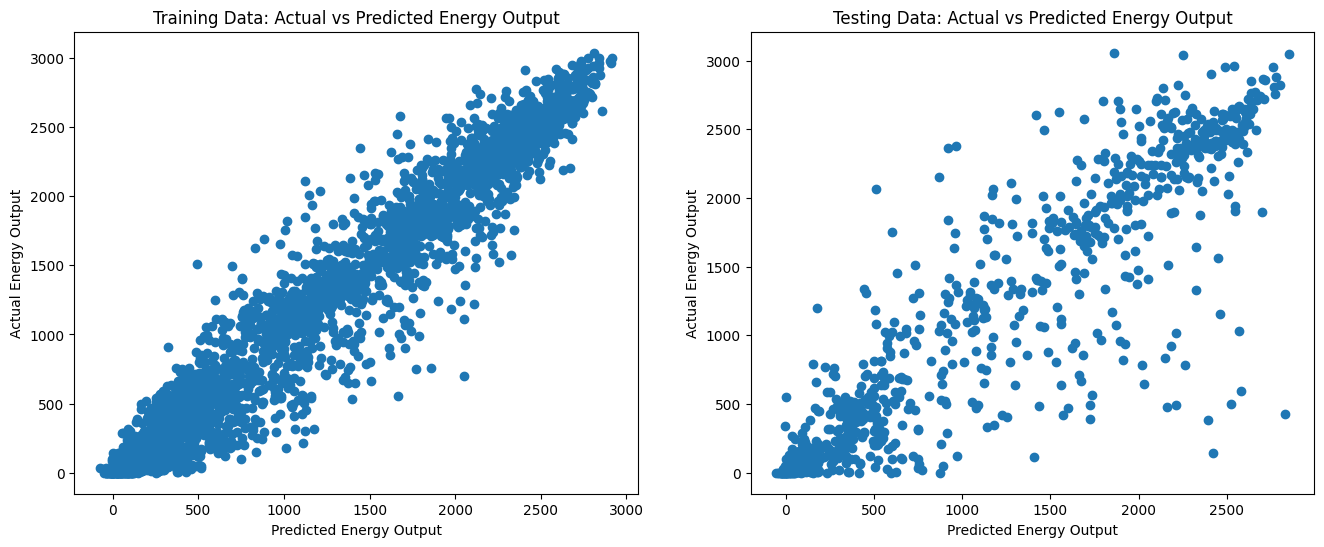

In [67]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,2)
plt.scatter(y_pred, y_test)
plt.xlabel('Predicted Energy Output')
plt.ylabel('Actual Energy Output')
plt.title('Testing Data: Actual vs Predicted Energy Output')

plt.subplot(1,2,1)
plt.scatter(stack_reg.predict(x_train), y_train)
plt.xlabel('Predicted Energy Output')
plt.ylabel('Actual Energy Output')
plt.title('Training Data: Actual vs Predicted Energy Output')
plt.show()

In [88]:
# stack_reg.predict(x_test) has shape (843,) and y_test has shape (843, 1)

# Reshape the first array to have the same number of dimensions as y_test
stack_reg_predictions = stack_reg.predict(x_test).reshape(-1, 1)

results = np.concatenate((stack_reg_predictions, y_test), 1)
results = pd.DataFrame(data = results)
results.columns = ['Predicted Energy Output', 'Actual Energy Output']
pd.options.display.float_format = "{:,.2f}".format

In [89]:
results.head()

,Predicted Energy Output,Actual Energy Output
0,"2,437.96","2,511.24"
1,329.41,480.21
2,"1,840.96","2,017.57"
3,275.61,760.14
4,108.26,220.40


In [92]:
r2_score(stack_reg_predictions, y_test)

0.786907194512566